# Payout Tutorial

In [19]:
import sys
sys.path.append('../src')
import payout

## Main function for payout

To generate a payout distribution, simply use the following function

`payout(winners, prize_pool, first_prize, entry_fee, num_buck, save_file='payout.csv')`

This function will create a *csv* file containing the position winners (first column) and the associate prize (second column). 

As an example, suppose we have 100 winners that we want to distribute over 7 buckets. Moreover, let's suppose that we have a prize pool of 50 000\$ and that the first prize winner is 10 000\$. We set the entry fee at 25\$.

In [2]:
# Calling this function will create a csv file containing the payout distribution
payout.payout(100, 50000, 10000, 25, 7, 'payout_100wins_50000prizepool.csv')

In [3]:
payout.payout(1000, 10000, 1000, 5, 10, 'payout_1000wins_10000prizepool.csv')

# Details of the code

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [20]:
from prizes import get_unperfect_prize, init_prizes, spend_leftover
from buckets import init_buck_size
from utils import write_to_csv

This part of the tutorial is more intended to the developer. We explain the main function in the code.

## Step 1 : define the variables

Let's suppose that we have 5000 participants, with an entry fee $E$ of 5\$. We choose that 25% of all the participants are winners $N$ (1250). With service charge of 10%. The winner receive 20% of the prize pool that we note prize_1 by $P_1$. Prize_pool is denoted by $B$.

In [6]:
participants = 5000
winners = int(0.25*participants)
entry_fee = 5
prize_pool = participants*entry_fee*0.90
prize_1 = 0.20*prize_pool

In [7]:
print('Number of winners = ',winners, 'Prize pool = ', prize_pool,'$ First place prize = ', prize_1)

Number of winners =  1250 Prize pool =  22500.0 $ First place prize =  4500.0


To use this algorithm we also need to provide a number of buckets. At least 4 buckets must be given. Note: I don't have a good rule of thumb for this number...

In [8]:
num_buck = 10

## Step 2 : Generate the unperfect prize distribution

This step will generate a list of prizes $\pi_i$, such that $\pi_1 = $ prize_1 and $\sum_i \pi_i = $ prize_pool. These prizes are define by the following equation:
$$
\pi_i = E + \frac{P_1 - E}{i^\alpha}
$$
with $\alpha$ a fixed constant obtained using an optimization procedure.

To generate the list of unperfect prizes, we will use the function `get_unperfect_prize(num_wins, prize_pool, price1, entry_fee)`

The following condition must hold,
$$
B \gt N\times E
$$
otherwise an error will be thrown.
Note that the argument *entry_fee* can be greater than the real entry_fee state at the start.

In [9]:
# get_unperfect_prize
unperfect_prize = get_unperfect_prize(winners, prize_pool, prize_1, entry_fee)

In [10]:
# Let's check that unperfect_prize[0] = prize_1 and that sum(unperfect_prize) = winners
print('First prize = ', unperfect_prize[0], '$ Prize pool = ', int(sum(unperfect_prize)),'$')

First prize =  4500.0 $ Prize pool =  22500 $


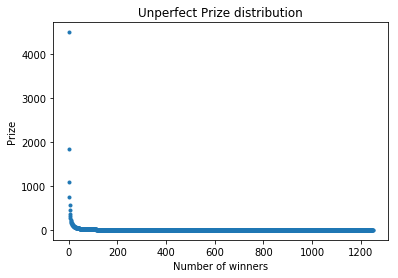

In [11]:
# Let's look at the current prizes distribution
plt.plot(unperfect_prize, '.')
plt.xlabel('Number of winners')
plt.ylabel('Prize')
plt.title('Unperfect Prize distribution')
plt.show()

## Step 3 : Generate the bucket size distribution

We already state the we wanted a certain number of bucket. Now, we need to generate the size of each bucket. By convention, the first 4 bucket will have size 1. The rest of the bucket will grow monotically according to a power law.

To generate the bucket sizes, we will use the function:

`init_buck_size(num_wins, num_bucks)`

This function will return a list $S$ were each element $s_i$ correspond to the size of the bucket $i$. 

In [12]:
bucket_sizes = init_buck_size(winners, num_buck)

In [13]:
# The sum of bucket_sizes must be equal to the number of winners
print("Number of winners is", sum(bucket_sizes))

Number of winners is 1250


In [14]:
# Let's plot the bucket size distribution
x = np.arange(len(bucket_sizes))
plt.bar(x, bucket_sizes)
plt.xlabel('# Bucket')
plt.ylabel('Size')
plt.title('Bucket size distribution')
plt.show()

## Step 4 : Initialize the prizes to nice numbers

This step will generate a new prizes list based on the unperfect prizes distribution and the bucket size distribution. The new list generated will be compose of nice numbers. 

To initialize the prizes to nice numbers, we will use the function:

`init_prizes(unperfect_prize, bucket_sizes)`

This function will return the list of prizes along with a leftover. Later, we will take care of this leftover.


In [21]:
init_prizes, leftover = init_prizes(unperfect_prize, bucket_sizes)

In [22]:
print('We have a leftover of :', int(leftover),'$')

We have a leftover of : 180 $


In [23]:
from utils import step_axis

# Let's plot the init_prizes distribution
x_axis, y_axis = step_axis(bucket_sizes, init_prizes)
plt.step(x_axis, y_axis)
# Partial view of the plot
plt.xlim(0, 150)
plt.ylim(0, 600)
plt.xlabel('Number of winners')
plt.ylabel('Prize')
plt.title('Initial prizes')
plt.show()

In [24]:
# Let's look directly with the list
print('initial prizes = ', init_prizes)
print('bucket size = ', bucket_sizes)

initial prizes =  [4500, 1750, 1000, 900, 400, 175, 60, 20, 8, 6]
bucket size =  [1, 1, 1, 1, 4, 10, 30, 90, 274, 838]


From these two lists, we have the following: 
* Prize 1 = 4500$ (Like we decided first)

* Prize 2 = 1750$

* Prize 3 = 1000$

* Prize 4 = 900$

* Prize 5-8 = 400$

* Prize 9-18 = 175$

* Prize 19-48 = 60$

* Prize 49-138 = 20$

* Prize 139-412 = 8$

* Prize 413-1250 = 6$ (Slightly above the entry fee)

Also don't forget, we have a leftover of 180$ that we need to distribute amongs the winners.

## Step 5 : Distribute the leftover

In this step, we will simply try to distribute some amount to the 2-4 positions. If it is not possible then, we will distribute in the last buckets. Note that this step may change some nice number to bad number...

To distribute the leftover, we will use the function:

`spend_leftover(prizes, bucket_sizes, leftover)`

This function will return the list of final prizes, a bucket size list and the final leftover. Note that this process may also, change some bucket sizes (to implement...), that's why we return the bucket size list. Also, the final leftover, will be set to 0 or can be less than a certain threshold that we must fix. 


In [25]:
final_prizes, final_bucket_sizes, final_leftover = spend_leftover(init_prizes, bucket_sizes, leftover)

In [26]:
final_prizes

[4500, 1750, 1000, 950, 400, 176, 61, 21, 8, 6]

In [27]:
final_leftover

0.00031466287578041374

## Step 6 : Write to a file

For this step, we process the final_prizes along with bucket_size to obtain a resulting csv file. To do so, we use the function:

`write_to_csv(prizes, bucket_size, leftover, file_name='payout.csv')`

In [ ]:
write_to_csv(final_prizes, final_bucket_sizes, final_leftover, file_name='payout_1250wins_22500prizepool.csv')